<a href="https://colab.research.google.com/github/SarkarPriyanshu/DataScienceAssign/blob/main/Co2_Emission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install plotly --q
!pip install feature-engine --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.1/357.1 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 64.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 2.2.2 which is incompatible.
google-colab 1.0.0 requires pandas==2.1.4, but you have pandas 2.2.2 which is incompatible.


In [4]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d debajyotipodder/co2-emission-by-vehicles

Dataset URL: https://www.kaggle.com/datasets/debajyotipodder/co2-emission-by-vehicles
License(s): DbCL-1.0
  0% 0.00/88.3k [00:00<?, ?B/s]
100% 88.3k/88.3k [00:00<00:00, 46.9MB/s]


In [5]:
import zipfile

zip_ref = zipfile.ZipFile("/content/co2-emission-by-vehicles.zip", 'r')
zip_ref.extractall("/content/")
zip_ref.close()

In [107]:
import regex as re
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from scipy import stats
from scipy.stats import pearsonr,normaltest

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from feature_engine.outliers import Winsorizer

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error,r2_score


pd.set_option('display.max_columns', None)

In [7]:
df = pd.read_csv('/content/CO2 Emissions_Canada.csv')

## Basic Analysis

In [8]:
df.shape

(7385, 12)

In [9]:
df.sample(5)

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
2160,VOLKSWAGEN,GOLF SPORTWAGON,STATION WAGON - SMALL,1.8,4,M5,X,9.5,6.6,8.2,34,189
2651,FORD,TRANSIT CONNECT WAGON LWB FFV,SPECIAL PURPOSE VEHICLE,2.5,4,AS6,X,12.4,8.7,10.7,26,252
4438,BENTLEY,FLYING SPUR,MID-SIZE,6.0,12,AS8,Z,20.4,12.0,16.6,17,389
7300,SUBARU,Impreza 4-Door AWD,MID-SIZE,2.0,4,AV7,X,8.3,6.4,7.5,38,174
458,GMC,SIERRA 4WD,PICKUP TRUCK - STANDARD,4.3,6,A6,X,14.2,10.6,12.6,22,290


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Make                              7385 non-null   object 
 1   Model                             7385 non-null   object 
 2   Vehicle Class                     7385 non-null   object 
 3   Engine Size(L)                    7385 non-null   float64
 4   Cylinders                         7385 non-null   int64  
 5   Transmission                      7385 non-null   object 
 6   Fuel Type                         7385 non-null   object 
 7   Fuel Consumption City (L/100 km)  7385 non-null   float64
 8   Fuel Consumption Hwy (L/100 km)   7385 non-null   float64
 9   Fuel Consumption Comb (L/100 km)  7385 non-null   float64
 10  Fuel Consumption Comb (mpg)       7385 non-null   int64  
 11  CO2 Emissions(g/km)               7385 non-null   int64  
dtypes: flo

In [11]:
null_counts = round(df.isna().sum()/df.shape[0]*100,2).reset_index()
null_counts = null_counts.rename(columns={'index':'Features',0:'Null Counts in %'})
null_counts = null_counts.sort_values(by='Null Counts in %')
display(null_counts)
fig = px.bar(null_counts, x='Features', y='Null Counts in %')
fig.show()

,Features,Null Counts in %
0,Make,0.0
1,Model,0.0
2,Vehicle Class,0.0
3,Engine Size(L),0.0
4,Cylinders,0.0
5,Transmission,0.0
6,Fuel Type,0.0
7,Fuel Consumption City (L/100 km),0.0
8,Fuel Consumption Hwy (L/100 km),0.0
9,Fuel Consumption Comb (L/100 km),0.0


In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Engine Size(L),7385.0,3.160068,1.354170,0.9,2.0,3.0,3.7,8.4
Cylinders,7385.0,5.615030,1.828307,3.0,4.0,6.0,6.0,16.0
Fuel Consumption City (L/100 km),7385.0,12.556534,3.500274,4.2,10.1,12.1,14.6,30.6
Fuel Consumption Hwy (L/100 km),7385.0,9.041706,2.224456,4.0,7.5,8.7,10.2,20.6
Fuel Consumption Comb (L/100 km),7385.0,10.975071,2.892506,4.1,8.9,10.6,12.6,26.1
Fuel Consumption Comb (mpg),7385.0,27.481652,7.231879,11.0,22.0,27.0,32.0,69.0
CO2 Emissions(g/km),7385.0,250.584699,58.512679,96.0,208.0,246.0,288.0,522.0


In [13]:
df.describe(include='O').T

,count,unique,top,freq
Make,7385,42,FORD,628
Model,7385,2053,F-150 FFV 4X4,32
Vehicle Class,7385,16,SUV - SMALL,1217
Transmission,7385,27,AS6,1324
Fuel Type,7385,5,X,3637


In [14]:
df.duplicated().sum()

1103

In [15]:
df.drop_duplicates(inplace=True)

In [16]:
df.shape

(6282, 12)

## EDA

In [17]:
NumericalFeatures = list(df.select_dtypes(exclude='O').columns)
CategoricalFeatures = list(df.select_dtypes(include='O').columns)

In [18]:
def showNumericalFeaturePlots(feature1=None,feature2=None,data=None):
  # Create subplots: one row, two columns
  fig = make_subplots(rows=2, cols=2, subplot_titles=(f'Scatter Plot', f'Box Plot'))

  # Add scatter plot to the first subplot
  fig.add_trace(
      go.Scatter(x=data[feature1], y=data[feature2], mode='markers', name='Scatter Plot'),
      row=1, col=1
  )

  # Add box plot to the second subplot
  fig.add_trace(
      go.Box(y=data[feature1], name='Box Plot'),
      row=1, col=2
  )

  # Add scatter plot to the first subplot
  fig.add_trace(
      go.Scatter(x=np.log(data[feature1]), y=data[feature2], mode='markers', name='After Log Scatter Plot'),
      row=2, col=1
  )

  # Add box plot to the second subplot
  fig.add_trace(
      go.Box(y=np.log(data[feature1]), name='After LogBox Plot'),
      row=2, col=2
  )

  # Update layout
  fig.update_layout(
      title_text=f"{feature1} vs {feature2}",
      showlegend=True
  )

  # Check for pearson correlation with target columns
  stat_ind, p_ind = pearsonr(data[feature1],data[feature1])
  if p_ind < 0.05:
    print(f'({feature1} and {feature2} Probably dependent) p-value : {p_ind}')
  else:
    print(f'({feature1} and {feature2} Probably independent) p-value : {p_ind}')

  # Show plot
  fig.show()
  print()

In [19]:
for feature in NumericalFeatures:
  if feature != 'CO2 Emissions(g/km)':
    showNumericalFeaturePlots(feature,'CO2 Emissions(g/km)',df)

(Engine Size(L) and CO2 Emissions(g/km) Probably dependent) p-value : 0.0



(Cylinders and CO2 Emissions(g/km) Probably dependent) p-value : 0.0



(Fuel Consumption City (L/100 km) and CO2 Emissions(g/km) Probably dependent) p-value : 0.0



(Fuel Consumption Hwy (L/100 km) and CO2 Emissions(g/km) Probably dependent) p-value : 0.0



(Fuel Consumption Comb (L/100 km) and CO2 Emissions(g/km) Probably dependent) p-value : 0.0



(Fuel Consumption Comb (mpg) and CO2 Emissions(g/km) Probably dependent) p-value : 0.0


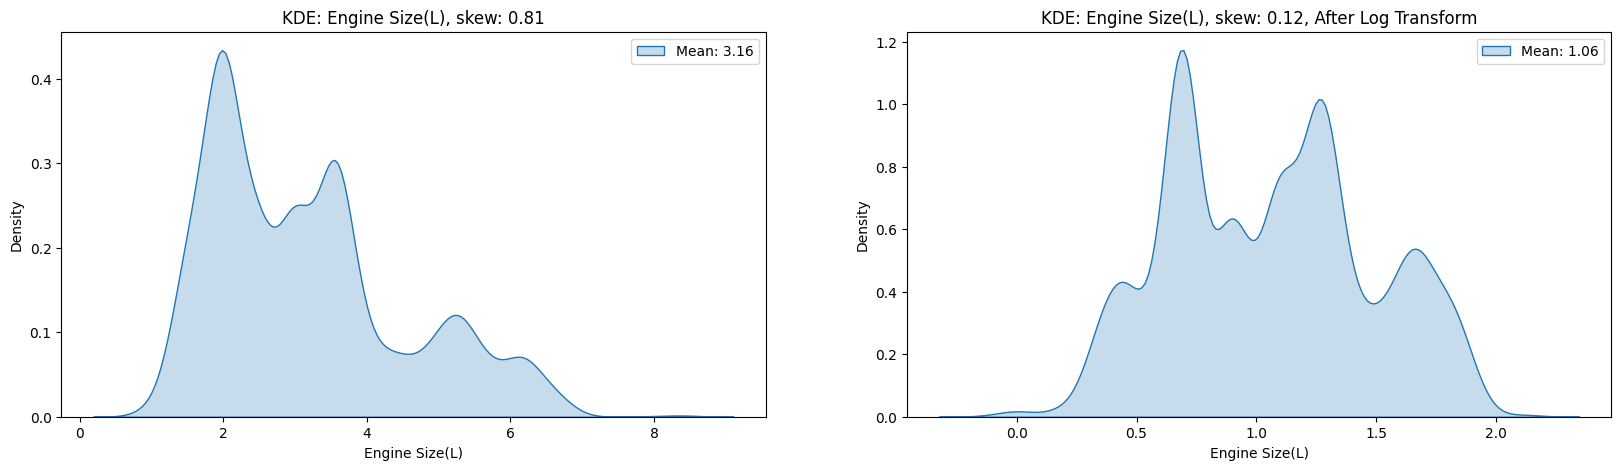

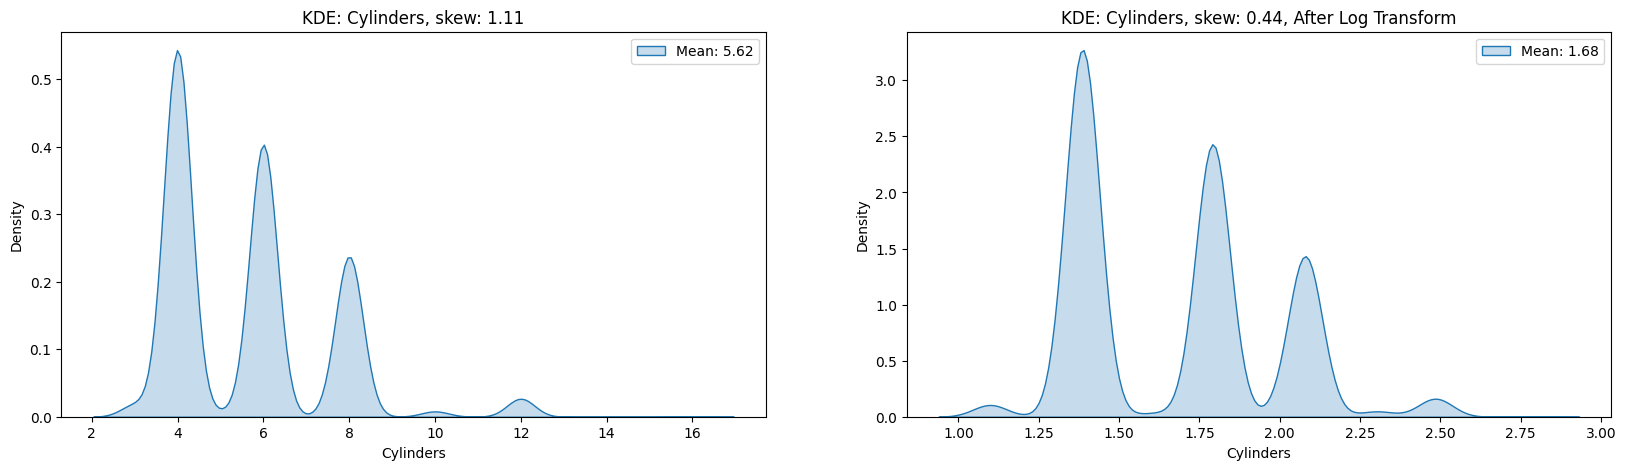

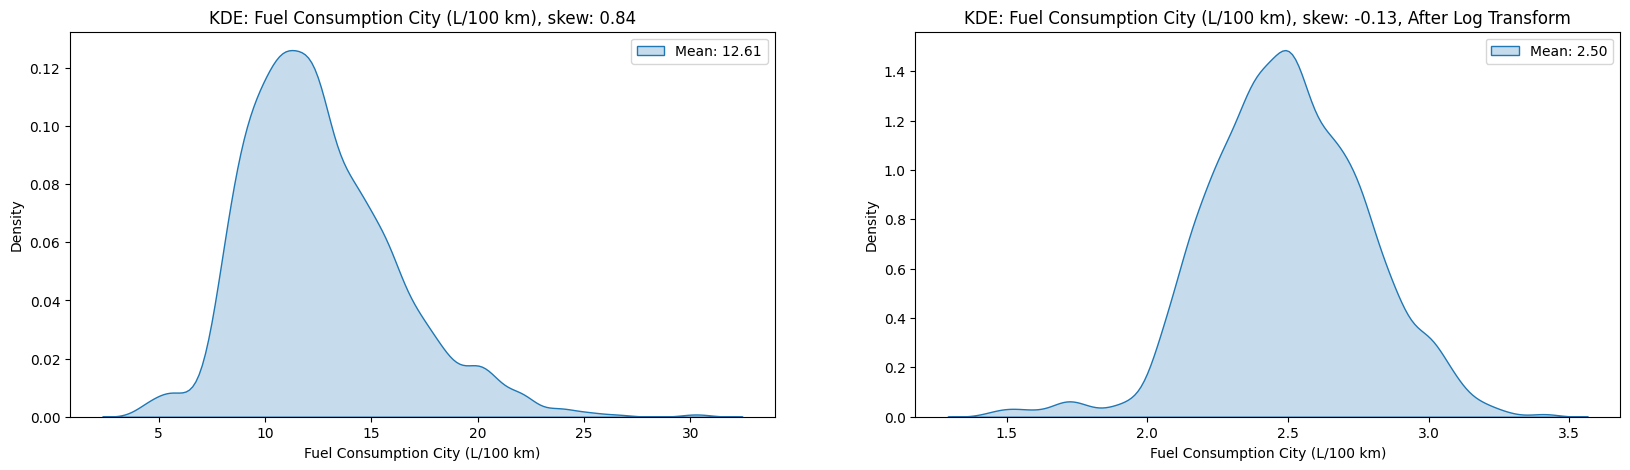

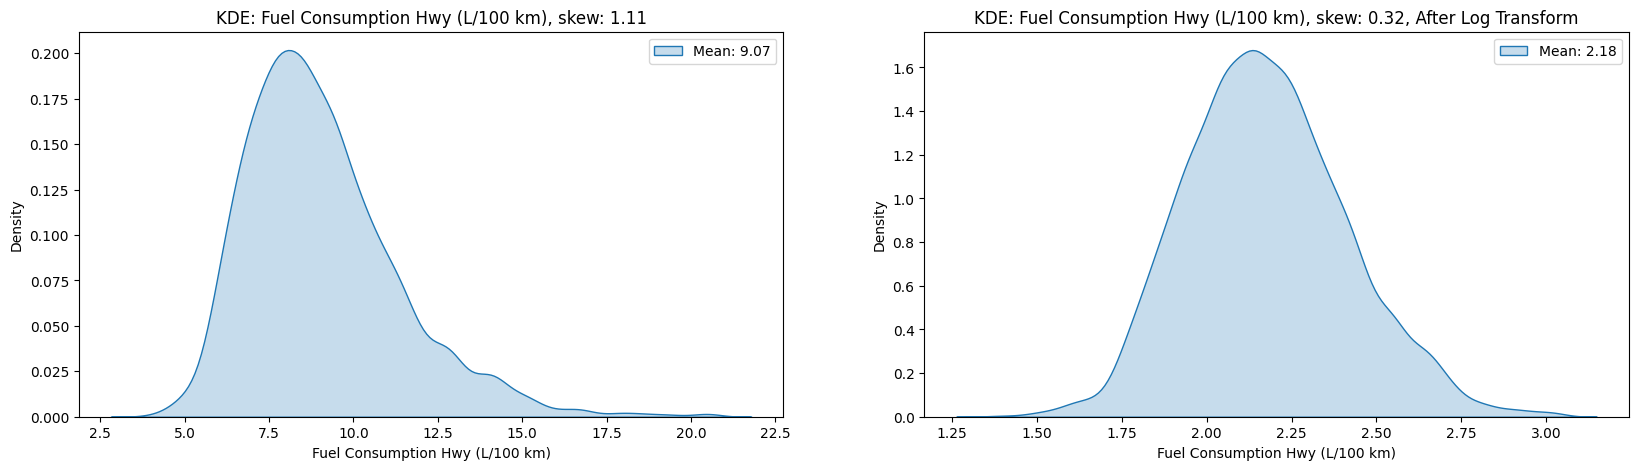

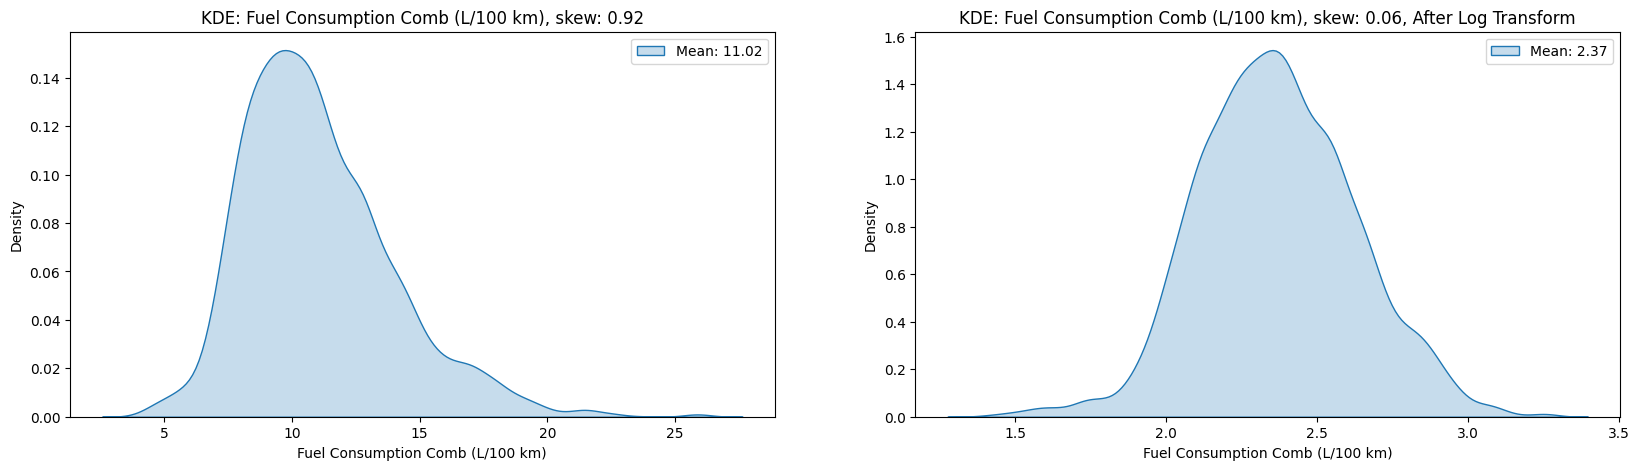

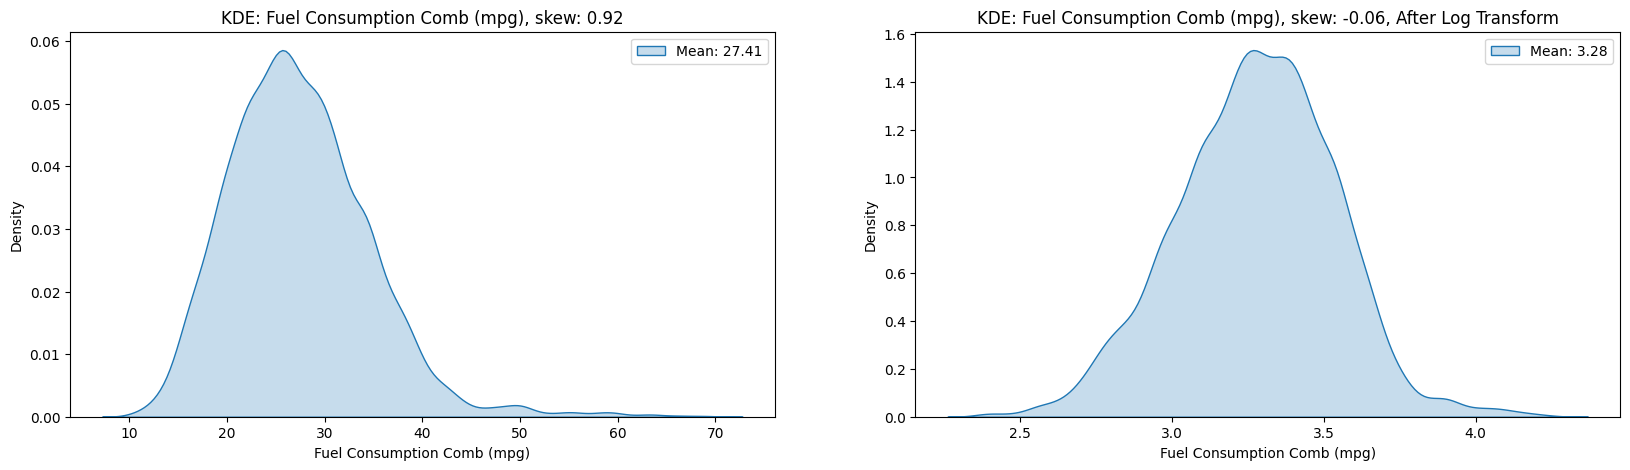

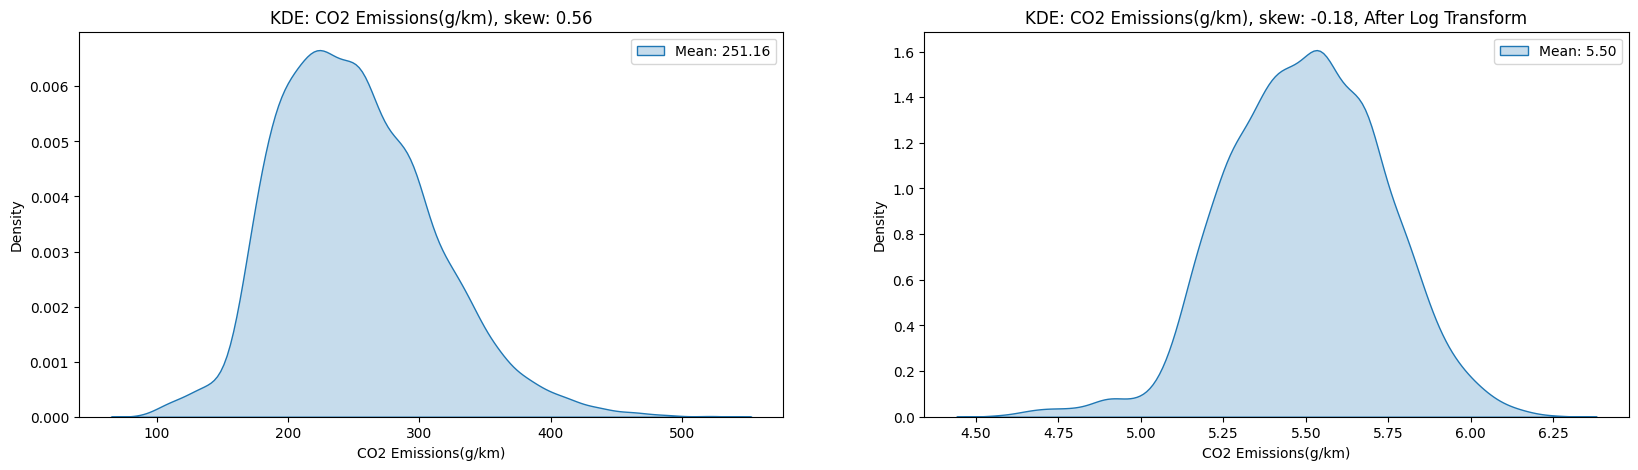

In [20]:
for feature in NumericalFeatures:
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))

    # Original feature KDE
    mean_original = df[feature].mean()
    median_original = df[feature].median()
    skew_original = df[feature].skew()

    sns.kdeplot(df[feature], fill=True, ax=ax[0])
    ax[0].set_title(f'KDE: {feature}, skew: {round(skew_original, 2)}')
    ax[0].legend([f'Mean: {mean_original:.2f}', f'Median: {median_original:.2f}'], loc='best')

    # Log-transformed feature KDE
    log_feature = np.log(df[feature])  # Added 1 to avoid log(0) issues
    mean_log = log_feature.mean()
    median_log = log_feature.median()
    skew_log = log_feature.skew()

    sns.kdeplot(log_feature, fill=True, ax=ax[1])
    ax[1].set_title(f'KDE: {feature}, skew: {round(skew_log, 2)}, After Log Transform')
    ax[1].legend([f'Mean: {mean_log:.2f}', f'Median: {median_log:.2f}'], loc='best')

    plt.show()

In [21]:
def getOutlierValues(feature,data):
  q1 = data[feature].quantile(.50)
  q3 = data[feature].quantile(.75)
  iqr = q3-q1
  lower_bound = q1-(1.5 * iqr)
  upper_bound = q3+(1.5 * iqr)

  # mean = data[feature].mean()
  # std_dev = data[feature].std()

  #   # Calculate bounds
  # lower_bound = mean - 3 * std_dev
  # upper_bound = mean + 3 * std_dev

  return data[(data[feature]<lower_bound) | (data[feature]>upper_bound)][feature].values

len(getOutlierValues('Engine Size(L)',df) )

1879

In [22]:
OutlierCounts = dict().fromkeys(NumericalFeatures)

for feature in NumericalFeatures:
  OutlierCounts[feature] = len(getOutlierValues(feature,df))

fig = px.bar(x=list(OutlierCounts.keys()), y=list(OutlierCounts.values()))

# Update layout to add title and axis labels
fig.update_layout(
    title='Outlier Counts for Different Features',
    xaxis_title='Features',
    yaxis_title='Count',
)

# Show the plot
fig.show()

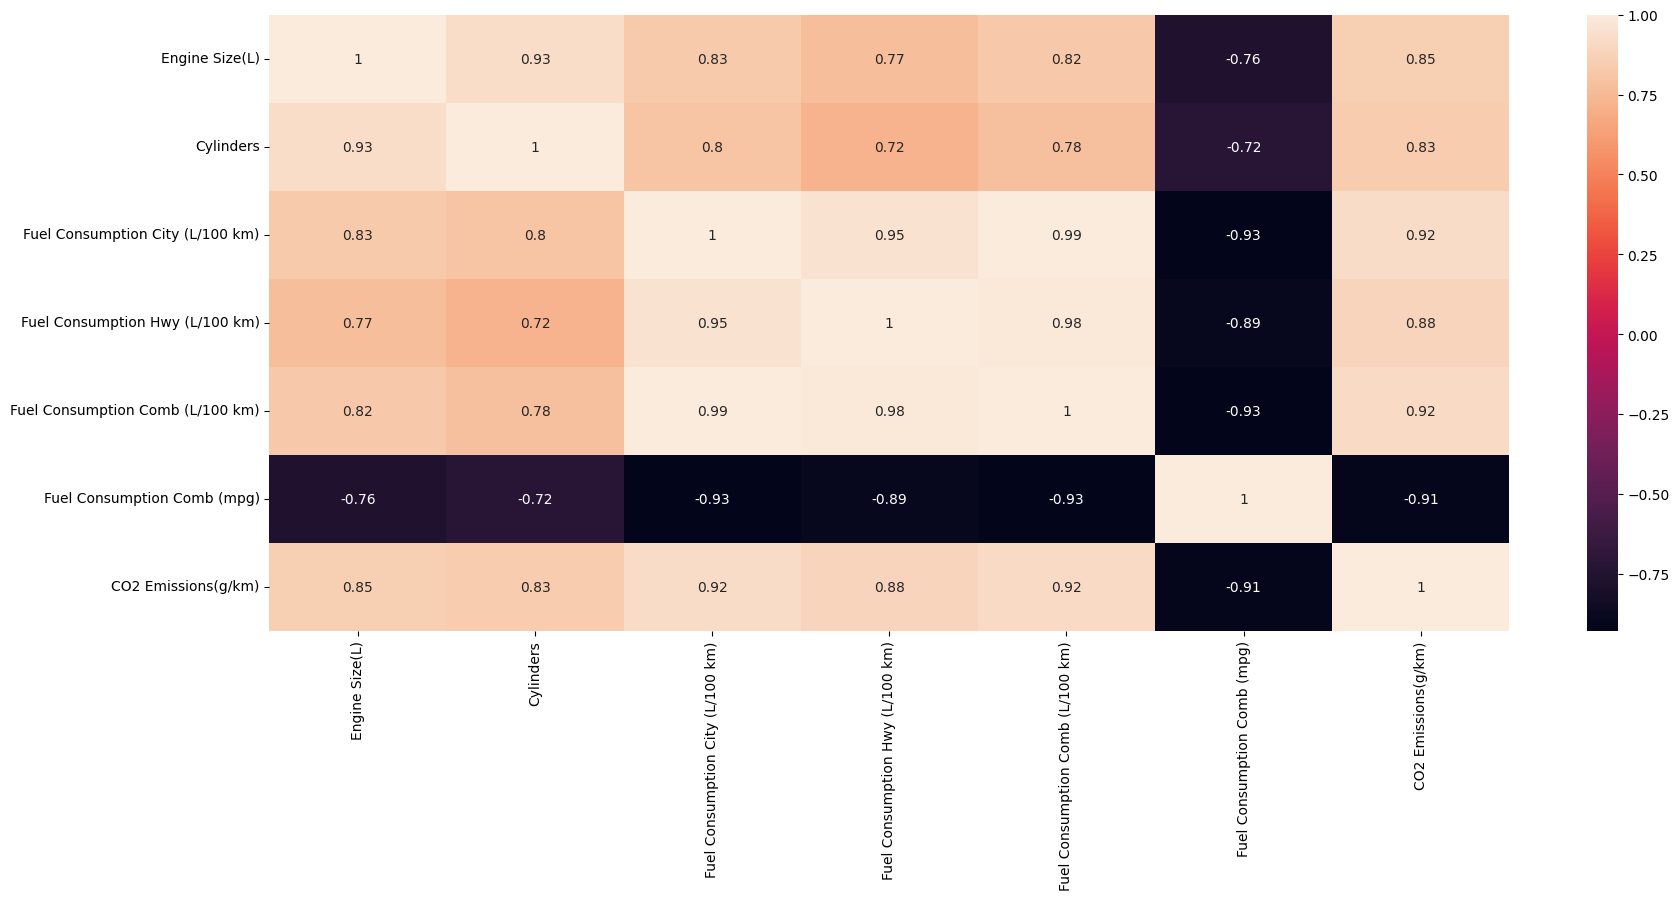

In [23]:
plt.figure(figsize=(20,8))
sns.heatmap(df[NumericalFeatures].corr(),annot=True)
plt.show()

In [24]:
for feature in CategoricalFeatures:
  print(f'{feature} : {df[feature].nunique()}')
  print()

Make : 42

Model : 2053

Vehicle Class : 16

Transmission : 27

Fuel Type : 5



## Experimentation

In [25]:
Final_Exp_Features = NumericalFeatures + ['Fuel Type']

In [26]:
exp_df = df[Final_Exp_Features]

In [27]:
exp_df.sample(5)

,Engine Size(L),Cylinders,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km),Fuel Type
4653,6.2,8,17.6,10.7,14.5,19,339,Z
207,2.4,4,11.5,8.2,10.0,28,230,X
2180,3.6,6,14.1,10.4,12.4,23,292,Z
1609,2.4,4,6.6,5.9,6.3,45,145,X
1560,5.3,8,22.1,15.4,19.1,15,306,E


In [28]:
exp_df = pd.get_dummies(exp_df,columns=['Fuel Type'],dtype=int,drop_first=True)

In [29]:
train,test = train_test_split(exp_df,test_size=0.3,random_state=101)

In [30]:
train.shape,test.shape

((4397, 11), (1885, 11))

In [88]:
scaling_features = ['Engine Size(L)', 'Cylinders', 'Fuel Consumption City (L/100 km)',
       'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)',
       'Fuel Consumption Comb (mpg)']

In [32]:
train.sample(5)

,Engine Size(L),Cylinders,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km),Fuel Type_E,Fuel Type_N,Fuel Type_X,Fuel Type_Z
371,6.2,8,18.3,12.9,15.9,18,366,0,0,1,0
714,2.5,4,8.7,6.5,7.7,37,177,0,0,1,0
1955,3.8,6,14.3,10.5,12.6,22,290,0,0,0,1
4841,5.3,8,19.8,13.9,17.2,16,285,1,0,0,0
1689,2.4,4,11.2,8.6,10.0,28,230,0,0,1,0


In [33]:
X_train = train.drop('CO2 Emissions(g/km)',axis=1)
y_train = train['CO2 Emissions(g/km)']
X_test = test.drop('CO2 Emissions(g/km)',axis=1)
y_test = test['CO2 Emissions(g/km)']

In [34]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
X_train_scaled = sm.add_constant(X_train_scaled)

In [36]:
lr_model = sm.OLS(y_train,X_train_scaled).fit()

In [37]:
# model params
lr_model.params

,0
const,162.850660
x1,2.783262
x2,15.345810
x3,168.485100
x4,90.426989
x5,172.147695
x6,-55.621772
x7,-137.619505
x8,-111.301992
x9,-30.024576


In [38]:
print(lr_model.summary())

                             OLS Regression Results                            
Dep. Variable:     CO2 Emissions(g/km)   R-squared:                       0.992
Model:                             OLS   Adj. R-squared:                  0.992
Method:                  Least Squares   F-statistic:                 5.789e+04
Date:                 Wed, 31 Jul 2024   Prob (F-statistic):               0.00
Time:                         07:11:21   Log-Likelihood:                -13466.
No. Observations:                 4397   AIC:                         2.695e+04
Df Residuals:                     4386   BIC:                         2.702e+04
Df Model:                           10                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        162.8507      1.185    137.47

In [39]:
y_pred = lr_model.predict(X_train_scaled)

Text(0.5, 1.0, 'Distribution of Residuels')

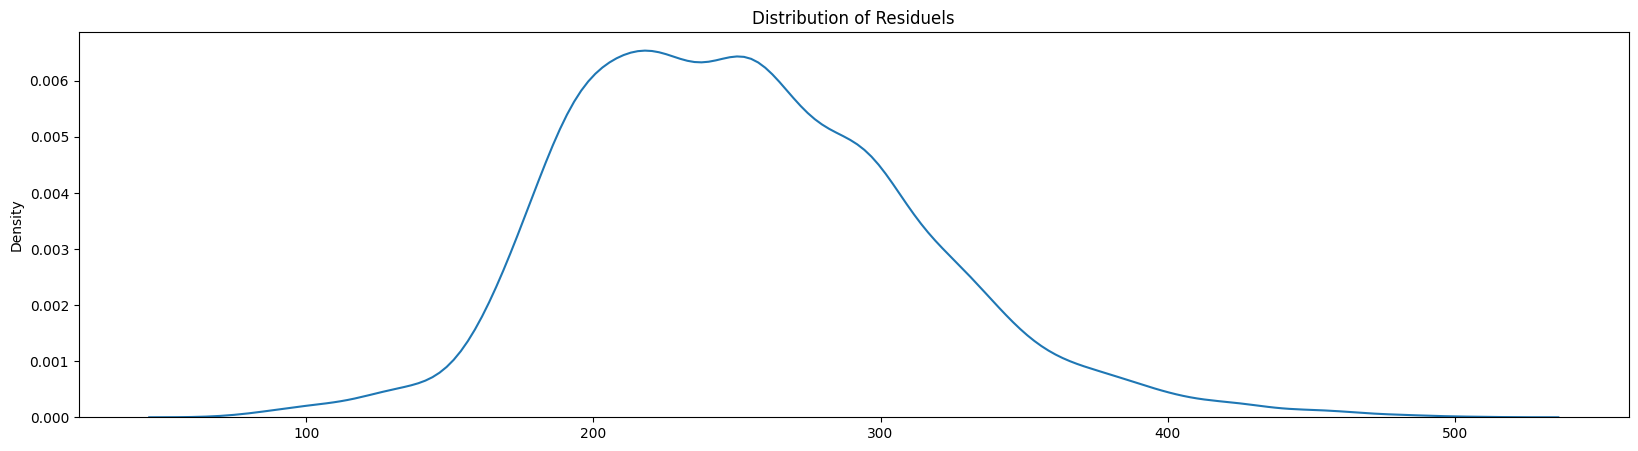

In [40]:
plt.figure(figsize=(20,5))
sns.kdeplot(y_pred)
plt.title('Distribution of Residuels')

In [41]:
# Performance on training data
np.sqrt(mean_squared_error(y_train,y_pred)),r2_score(y_train,y_pred)

(5.173952934454446, 0.9924801371637093)

In [42]:
X_test_scaled = sm.add_constant(X_test_scaled)

In [43]:
pred = lr_model.predict(X_test_scaled)

Text(0.5, 1.0, 'Distribution of Residuels')

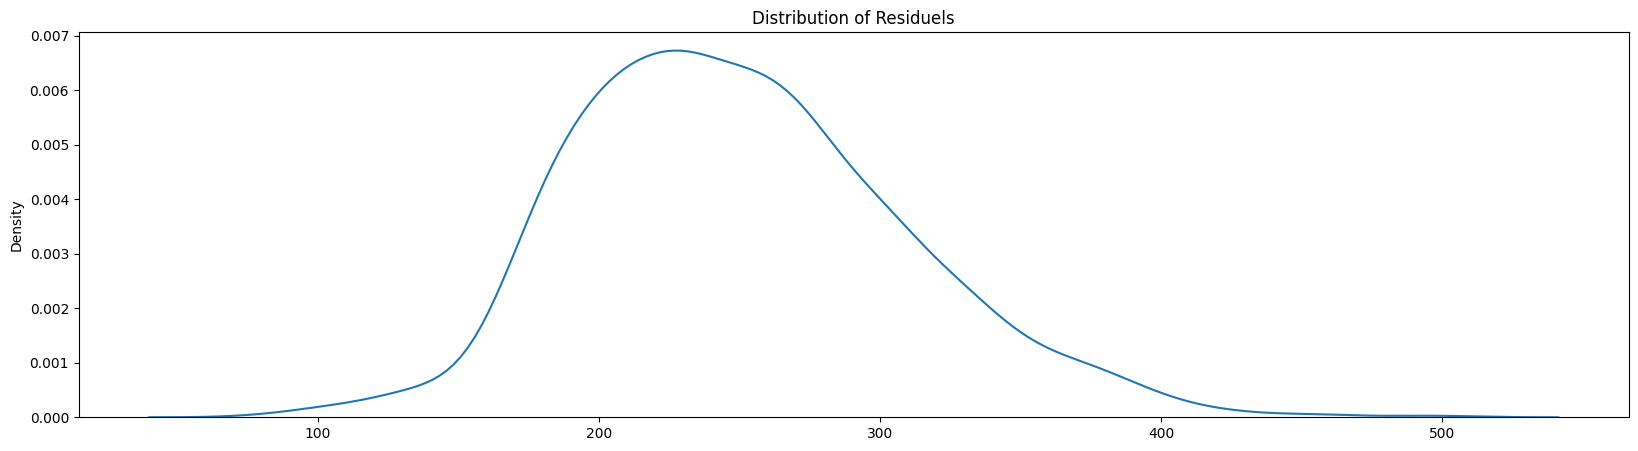

In [44]:
plt.figure(figsize=(20,5))
sns.kdeplot(pred)
plt.title('Distribution of Residuels')

In [45]:
# Performance on training data
np.sqrt(mean_squared_error(y_test,pred)),r2_score(y_test,pred)

(5.119725335264847, 0.9923072635910737)